# Fair Weather Pedalers
Harvard APMA-E207/AM207 Spring 2016 final project
Kevin Burek <kevin.burek@gmail.com> and Josh Mclellan <jvl.mclellan@gmail.com>

## Preliminary visualizations of Hubway ride data

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

import datetime as dt

In [2]:
# trips_csv = '../data/hubway_2011_07_through_2013_11/hubway_trips.csv'
trips_csv = '../data/hubway_2011_07_through_2013_11/fewer_hubway_trips.csv'
# trips_csv = '../data/hubway_2011_07_through_2013_11/hubway_trips.csv'

ride_data = np.genfromtxt(trips_csv, delimiter=',')
ride_df = pd.read_csv(trips_csv)

In [3]:
ride_df.head()

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
0,1,8,Closed,9,7/28/2011 10:12:00,23,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male
1,2,9,Closed,220,7/28/2011 10:21:00,23,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male
2,3,10,Closed,56,7/28/2011 10:33:00,23,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male
3,4,11,Closed,64,7/28/2011 10:35:00,23,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female
4,5,12,Closed,12,7/28/2011 10:37:00,23,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female


### Adding calculated columns
In order to analyze the data easily, we need to add some columns to the data frame that extract deterministic properties of the data rows.  Such as day of week and hour of day, from the otherwise plaintext start_date and end_date columns. 

In [19]:
# Figure out how to parse an example time value.
egtime = ride_df['start_date'][0]
import dateutil.parser as dtp
time = dtp.parse(egtime)

for endpoint in ('start', 'end'):
    %time ride_df.loc[:, endpoint + '_datetime'] = [dtp.parse(d) for d in ride_df[endpoint + '_date']]
    weekdays = [d.weekday() for d in ride_df[endpoint + '_datetime']]
    ride_df.loc[:,endpoint + '_weekday'] = pd.Series(weekdays, index = ride_df.index)
    daytimes = [d.time() for d in ride_df[endpoint + '_datetime']]
    ride_df.loc[:,endpoint + '_time'] = pd.Series(daytimes, index = ride_df.index)

Wall time: 33.8 s
Wall time: 34.8 s


In [20]:
ride_df.head()

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,start_time,start_weekday,end_time,end_weekday,start_datetime,end_datetime
0,1,8,Closed,9,7/28/2011 10:12:00,23,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male,10:12:00,3,10:12:00,3,2011-07-28 10:12:00,2011-07-28 10:12:00
1,2,9,Closed,220,7/28/2011 10:21:00,23,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male,10:21:00,3,10:25:00,3,2011-07-28 10:21:00,2011-07-28 10:25:00
2,3,10,Closed,56,7/28/2011 10:33:00,23,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male,10:33:00,3,10:34:00,3,2011-07-28 10:33:00,2011-07-28 10:34:00
3,4,11,Closed,64,7/28/2011 10:35:00,23,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female,10:35:00,3,10:36:00,3,2011-07-28 10:35:00,2011-07-28 10:36:00
4,5,12,Closed,12,7/28/2011 10:37:00,23,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female,10:37:00,3,10:37:00,3,2011-07-28 10:37:00,2011-07-28 10:37:00


In [21]:
from numpy import array as A
ride_seconds = [(t.hour*60 + t.minute)*60 + t.second for t in ride_df['start_time']]

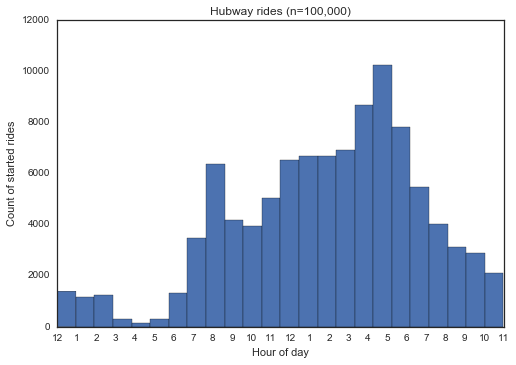

In [22]:
plt.hist(ride_seconds, bins=24)
plt.xlim((0, 24*3600))
plt.xticks(np.linspace(0,24*3600, 24))
plt.gca().set_xticklabels((np.arange(0,24,1) % 12 + 1)[(11,0,1,2,3,4,5,6,7,8,9,10)*2,])
plt.title("Hubway rides (n=100,000)")
plt.xlabel("Hour of day")
plt.ylabel("Count of started rides")
plt.show()

### Separating weekdays from weekends
<a name="HourRideHistogram"></a>

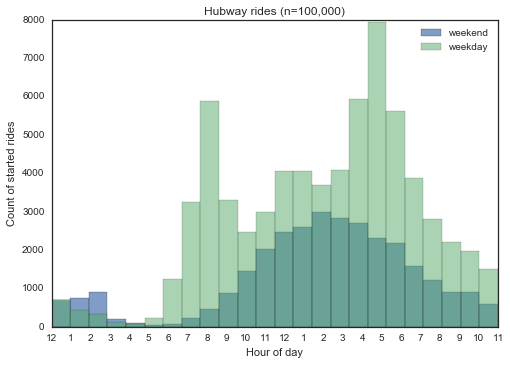

In [23]:

weekday_rides = ride_df[(ride_df['start_weekday'] < 5)]

weekday_ride_seconds = [(t.hour*60 + t.minute)*60 + t.second for t in weekday_rides['start_time']]

weekend_rides = ride_df[(ride_df['start_weekday'] >= 5)]
weekend_ride_seconds = [(t.hour*60 + t.minute)*60 + t.second for t in weekend_rides['start_time']]

plt.hist(weekend_ride_seconds, bins=24, label="weekend", alpha=.7)
plt.hist(weekday_ride_seconds, bins=24, label="weekday", alpha=.5)
plt.xlim((0, 24*3600))
plt.xticks(np.linspace(0,24*3600, 24))
plt.gca().set_xticklabels((np.arange(0,24,1) % 12 + 1)[(11,0,1,2,3,4,5,6,7,8,9,10)*2,])
plt.title("Hubway rides (n=100,000)")
plt.xlabel("Hour of day")
plt.ylabel("Count of started rides")
plt.legend()
plt.show()

we are now going to try to parse out rides which have traits we assume are associated with casual riders
assumptions:
    unregistered riders are all casual riders
    weekend riders are all causual riders 


In [24]:
ride_df[(ride_df['subsc_type'] != 'Registered')].describe()


,seq_id,hubway_id,duration,strt_statn,end_statn,birth_date,start_weekday,end_weekday
count,49580.000000,49580.000000,4.958000e+04,49580.000000,49568.000000,0.0,49580.000000,49580.000000
mean,44786.903812,50652.594232,6.336713e+03,34.030637,33.907077,NaN,3.570149,3.569141
std,29181.566488,33209.777836,1.350445e+05,15.041641,15.113448,NaN,2.075333,2.080773
min,13.000000,23.000000,5.000000e+00,3.000000,3.000000,NaN,0.000000,0.000000
25%,18805.750000,20747.750000,7.710000e+02,22.000000,22.000000,NaN,2.000000,2.000000
50%,42555.500000,48978.500000,1.410000e+03,36.000000,36.000000,NaN,4.000000,4.000000
75%,69225.750000,78498.750000,3.287000e+03,46.000000,46.000000,NaN,5.000000,5.000000
max,100000.000000,112988.000000,1.199446e+07,62.000000,64.000000,NaN,6.000000,6.000000


In [25]:
ride_df[(ride_df['subsc_type'] != 'Registered') | (ride_df['start_weekday'] == 0) | (ride_df['start_weekday'] == 6)].describe()


,seq_id,hubway_id,duration,strt_statn,end_statn,birth_date,start_weekday,end_weekday
count,61103.000000,61103.000000,6.110300e+04,61103.000000,61091.000000,11383.000000,61103.000000,61103.000000
mean,47157.357462,53352.751682,5.466786e+03,33.782417,33.706945,1976.058860,3.296041,3.295206
std,29029.362823,33035.438855,1.266818e+05,15.155951,15.220159,10.919163,2.316931,2.320274
min,13.000000,23.000000,0.000000e+00,3.000000,3.000000,1932.000000,0.000000,0.000000
25%,22229.500000,24574.500000,6.210000e+02,22.000000,22.000000,1969.000000,1.000000,1.000000
50%,45049.000000,51812.000000,1.177000e+03,36.000000,36.000000,1979.000000,4.000000,4.000000
75%,71303.500000,80900.000000,2.603000e+03,46.000000,46.000000,1985.000000,5.000000,5.000000
max,100000.000000,112988.000000,1.199446e+07,62.000000,64.000000,1994.000000,6.000000,6.000000


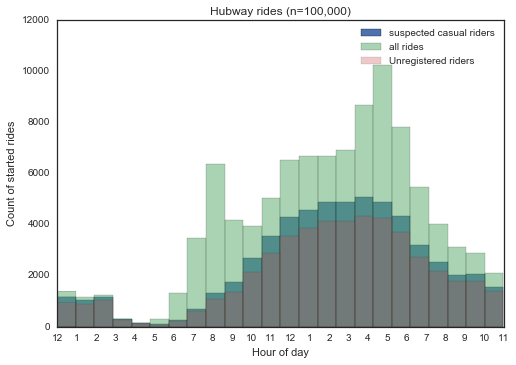

In [12]:
# best_guess_work_trips = ride_df[(ride_df['start_weekday'] > 0) & (ride_df['start_weekday'] < 6)]


# weekday_rides = ride_df[(ride_df['start_weekday'] > 0) & (ride_df['start_weekday'] < 6)]

casual_rides = ride_df[(ride_df['subsc_type'] != 'Registered') | (ride_df['start_weekday'] >= 5)]
causal_ride_seconds = [(t.hour*60 + t.minute)*60 + t.second for t in casual_rides['start_time']]

all_rides = ride_df
all_rides_seconds = [(t.hour*60 + t.minute)*60 + t.second for t in all_rides['start_time']]

only_unreg_rides = ride_df[(ride_df['subsc_type'] != 'Registered')]
only_unreg_rides_seconds = [(t.hour*60 + t.minute)*60 + t.second for t in only_unreg_rides['start_time']]

plt.hist(causal_ride_seconds, bins=24, label="suspected casual riders")
plt.hist(all_rides_seconds, bins=24, label="all rides", alpha=.5)
plt.hist(only_unreg_rides_seconds, bins=24,label="Unregistered riders", alpha=.3)

plt.xlim((0, 24*3600))
plt.xticks(np.linspace(0,24*3600, 24))
plt.gca().set_xticklabels((np.arange(0,24,1) % 12 + 1)[(11,0,1,2,3,4,5,6,7,8,9,10)*2,])
plt.title("Hubway rides (n=100,000)")
plt.xlabel("Hour of day")
plt.ylabel("Count of started rides")
plt.legend()
plt.show()



notes from the above graph:
    cut off should probably be from 4 - 5 since there is a clear continuity through our current data 
    
    also: this is really seems to be function of time as opposed to a distribution, as it seems that the wuantities are very different, which is in while with what we would expect 

In [13]:
casual_rides.describe()


,seq_id,hubway_id,duration,strt_statn,end_statn,birth_date,start_weekday,end_weekday
count,58469.000000,58469.000000,5.846900e+04,58469.00000,58455.000000,8779.000000,58469.000000,58469.000000
mean,46894.125212,53051.191554,5.527875e+03,34.00260,33.905620,1978.164597,3.857052,3.856249
std,29479.372663,33535.207088,1.243913e+05,15.18353,15.245522,10.080001,2.036924,2.042415
min,13.000000,23.000000,0.000000e+00,3.00000,3.000000,1932.000000,0.000000,0.000000
25%,20886.000000,23102.000000,6.610000e+02,22.00000,22.000000,1974.000000,2.000000,2.000000
50%,44499.000000,51197.000000,1.242000e+03,36.00000,36.000000,1981.000000,5.000000,5.000000
75%,70764.000000,80296.000000,2.774000e+03,46.00000,46.000000,1985.000000,5.000000,5.000000
max,100000.000000,112988.000000,1.199446e+07,62.00000,64.000000,1994.000000,6.000000,6.000000


In [14]:
%who


A	 all_rides	 all_rides_seconds	 casual_rides	 causal_ride_seconds	 d	 daytimes	 dt	 dtp	 
egtime	 endpoint	 matplotlib	 np	 only_unreg_rides	 only_unreg_rides_seconds	 pd	 plt	 pm	 
re	 ride_data	 ride_df	 ride_seconds	 scipy	 sns	 t	 time	 timeit	 
trips_csv	 weekday_ride_seconds	 weekday_rides	 weekdays	 weekend_ride_seconds	 weekend_rides	 


we need to add indicator variables so differentiate if causal rider or not

In [17]:
casual_rider_distribution = pm.Beta('casual', alpha=0.5, beta=0.5)

there are 86400 seconds in a day so we can create a time variable uniformly distributed between 0 and 86400 to describe the time of day for our model

describing the probability function for $p(d_w,t_d,\omega,| \mu_t, \sigma_t)$ (We haven't worked up to using $\lambda_c$ to describe rider commitment yet)



In [27]:
ride_df.loc[:,'1_if_subscribed'] = (np.array(ride_df['subsc_type']) == 'Registered').astype('l')
ride_df.loc[:,'start_seconds'] = [(t.hour*60 + t.minute)*60 + t.second for t in ride_df['start_time']]

ride_df.sample()

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,...,birth_date,gender,start_time,start_weekday,end_time,end_weekday,start_datetime,end_datetime,1_if_subscribed,start_seconds
91285,91286,103275,Closed,255,10/9/2011 22:38:00,36,10/9/2011 22:42:00,49.0,B00054,Registered,...,1985.0,Male,22:38:00,6,22:42:00,6,2011-10-09 22:38:00,2011-10-09 22:42:00,1,81480


In [15]:
# define stocastic variables for our model

# stocastic_time_of_departure = np.random.uniform(low = 0, high = 86400)
stocastic_time_of_departure = pm.distributions.discrete_uniform_like('departure_in_sec', lower = 0, upper = 86400)
# stocastic_day_of_week = np.random.uniform(low = 0, high = 7) #7 value used to deal with half open interval
stocastic_day_of_week = pm.distributions.discrete_uniform_like('start_weekday', lower = 0, upper = 7) #htis is 7 seperate paremeters
# stocastic_casual_p = np.random.binomial(n = 1, p = .25)
stocastic_casual_p = pm.distributions.bernoulli_like(' ', .25)


pymc.distributions.categorical_like(x, .5)


# pm.Model(stocastic_time_of_departure, stocastic_day_of_week, stocastic_casual_p)